In [1]:
import umap.umap_ as umap
import os
import numpy as np
from scipy.stats import ks_2samp, bootstrap
from scipy.stats import wasserstein_distance
from sklearn.utils import resample
from scipy.spatial.distance import cosine
import umap.umap_ as umap
import pandas as pd
import os
import numpy as np
import random
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy.stats import wasserstein_distance
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import numpy as np
from scipy.stats import permutation_test

c:\Users\m139105\Documents\phd\uni\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(all_samples_sorted)

['s_10_orig', 's_10_rep1', 's_10_rep2', 's_11_orig', 's_11_rep1', 's_11_rep2', 's_12_orig', 's_12_rep1', 's_12_rep2', 's_13_orig', 's_13_rep1', 's_13_rep2', 's_15_orig', 's_15_rep1', 's_15_rep2', 's_16_orig', 's_16_rep1', 's_16_rep2', 's_17_orig', 's_17_rep1', 's_17_rep2', 's_18_orig', 's_18_rep1', 's_18_rep2', 's_1_orig', 's_1_rep1', 's_1_rep2', 's_21_orig', 's_21_rep1', 's_21_rep2', 's_22_orig', 's_22_rep1', 's_22_rep2', 's_23_orig', 's_23_rep1', 's_23_rep2', 's_24_orig', 's_24_rep1', 's_24_rep2', 's_26_orig', 's_26_rep1', 's_26_rep2', 's_27_orig', 's_27_rep1', 's_27_rep2', 's_28_orig', 's_28_rep1', 's_28_rep2', 's_2_orig', 's_2_rep1', 's_2_rep2', 's_30_orig', 's_30_rep1', 's_30_rep2', 's_31_orig', 's_31_rep1', 's_31_rep2', 's_32_orig', 's_32_rep1', 's_32_rep2', 's_34_orig', 's_34_rep1', 's_34_rep2', 's_35_orig', 's_35_rep1', 's_35_rep2', 's_36_orig', 's_36_rep1', 's_36_rep2', 's_38_orig', 's_38_rep1', 's_38_rep2', 's_39_orig', 's_39_rep1', 's_39_rep2', 's_3_orig', 's_3_rep1', 's_3_r

C:\Users\m139105\AppData\Local\Temp\ipykernel_41732\4225121053.py:21: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


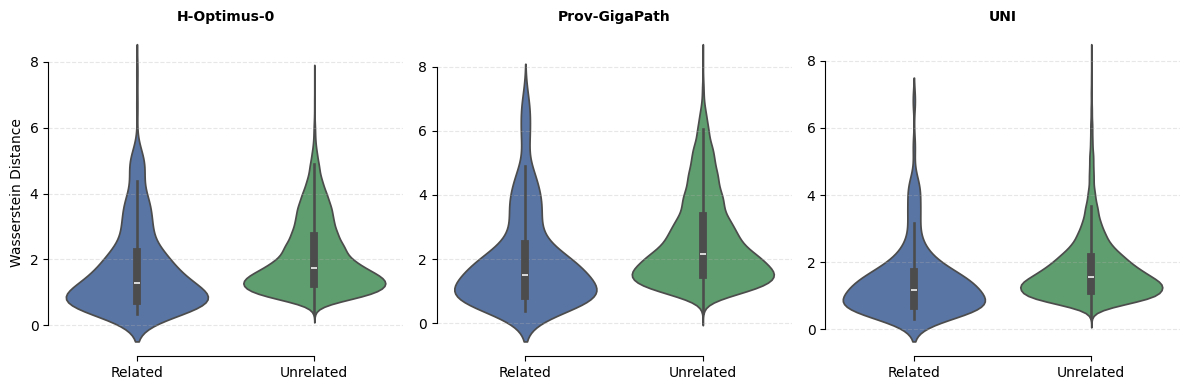

In [ ]:
import re
df = pd.read_csv("distances/distances/100/all_models.csv")

df = df[df["sample1"] != df["sample2"]]


def extract_prefix(sample):
    match = re.match(r"(s_\d+)", sample)
    return match.group(1) if match else sample

df["sample1_prefix"] = df["sample1"].apply(extract_prefix)
df["sample2_prefix"] = df["sample2"].apply(extract_prefix)

df["comparison"] = df.apply(
    lambda row: "Related" if row["sample1_prefix"] == row["sample2_prefix"] else "Unrelated",
    axis=1
)

pub_palette = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD"]

g = sns.catplot(
    data=df,
    x="comparison",
    y="wasserstein",
    hue="comparison",
    col="model",
    kind="violin",
    inner="box",
    palette=pub_palette,
    height=4,
    sharey=False
)

g.set_titles(col_template="{col_name}", fontweight="bold")
g.set_axis_labels("", "Wasserstein Distance")
for ax in g.axes.flat:
    ax.tick_params(axis="x")
    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.3)

sns.despine(trim=True)  # cleaner borders

plt.tight_layout()
plt.savefig("wasserstein_distance_raw.png", dpi=300)

In [5]:
df = pd.read_csv("distances/distances/100/all_models.csv")

df_filtered = df[df['sample1'] != df['sample2']]

df_filtered['label'] = df_filtered.apply(lambda x: 'within' if x['sample1'].split('_')[1] == x['sample2'].split('_')[1] else 'between', axis=1)

df_filtered.to_csv("filtered_all_models_assigned.csv", index=False)

def run_permutation_test(values, labels, n_permutations=10000):
    def statistic(group1, group2):
        return np.mean(group1) - np.mean(group2)
    
    within_values = values[labels == 'within']
    between_values = values[labels == 'between']
    
    res = permutation_test(
        (within_values, between_values),
        statistic,
        vectorized=False,
        n_resamples=n_permutations,
        alternative='less',
        random_state=42
    )
    return res.pvalue

results = []
for model in df_filtered['model'].unique():
    model_df = df_filtered[df_filtered['model'] == model]
    labels = model_df['label'].values
    
    for metric in ['wasserstein', 'mmd']:
        values = model_df[metric].values
        p_value = run_permutation_test(values, labels)
        results.append({'model': model, 'metric': metric, 'p_value': p_value})

results_df = pd.DataFrame(results)
print(results_df)

C:\Users\m139105\AppData\Local\Temp\ipykernel_41732\1782676663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered.apply(lambda x: 'within' if x['sample1'].split('_')[1] == x['sample2'].split('_')[1] else 'between', axis=1)


           model       metric  p_value
0    H-Optimus-0  wasserstein   0.0001
1    H-Optimus-0          mmd   0.0001
2  Prov-GigaPath  wasserstein   0.0001
3  Prov-GigaPath          mmd   0.0001
4            UNI  wasserstein   0.0001
5            UNI          mmd   0.0001


C:\Users\m139105\AppData\Local\Temp\ipykernel_41732\1075894487.py:1: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


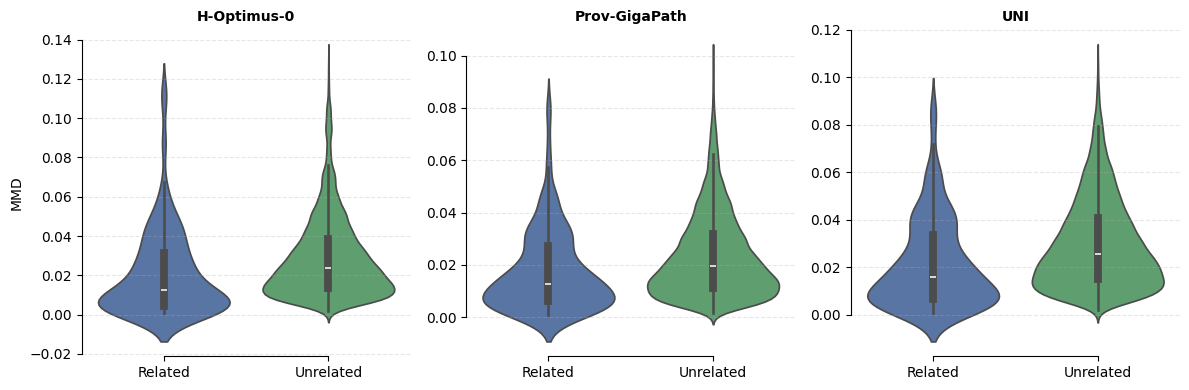

In [ ]:
g = sns.catplot(
    data=df,
    x="comparison",
    y="mmd",
    hue="comparison",
    col="model",
    kind="violin",
    inner="box",
    palette=pub_palette,
    height=4,
    sharey=False
)


g.set_titles(col_template="{col_name}", fontweight="bold")
g.set_axis_labels("", "MMD")
for ax in g.axes.flat:
    ax.tick_params(axis="x")
    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.3)

sns.despine(trim=True)

plt.tight_layout()
plt.savefig("mmd_Distance.png", dpi=300)